<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Intuition on synergy & redundancy

***

**Robust and impactful Data Science with FACET**

FACET enables us to perform several critical steps in best practice Data Science work flow easily, efficiently and reproducibly:

1. Create a robust pipeline for learner selection using LearnerRanker and cross-validation.

2. Enhance our model inspection to understand drivers of predictions using local explanations of features via [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) by applying a novel methodology that decomposes SHAP values into measures of synergy, redundancy, and independence between each pair of features.

3. Quickly apply historical simulation to gain key insights into feature values that minimize or maximize the predicted outcome.

***

**Context**

With the advanced capabilities FACET provides by extending SHAP-based model inspection, it is important to **gain some intuition for how the newly introduced measures for feature redundancy and synergy can vary**. As SHAP values represent post-processing after data preparation, feature engineering, preprocessing and model selection/tuning, minimal simulation studies offer a way to make the connection as direct as possible.

In this FACET tutorial we will conduct two simulation studies to gain intuition about synergy and redundancy:

1. Explore patterns in synergy and redundancy as a function of the individual and joint contribution of two continuous features in predicting a binary target where the features have varying degrees of correlation.
2. Explore how overfitting affects the accuracy of redundancy and synergy estimates for a random forest classifier by varying the `max_depth` parameter.

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Simulating data](#Simulating-data)
3. [Redundancy, Synergy and SHAP](#Redundancy,-Synergy-and-SHAP)
4. [Understanding how redundancy and synergy change with feature correlation and interaction](#Understanding-how-redundancy-and-synergy-change-with-feature-correlation-and-interaction)
5. [How overfitting affects the accuracy of redundancy and synergy estimates](#How-overfitting-affects-the-accuracy-of-redundancy-and-synergy-estimates)
6. [Summary](#Summary)
7. [What can you do next?](#What-can-you-do-next?)
8. [Appendix](#Appendix)

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os

    if "cwd" not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")


def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook

    # ignore a useless LGBM warning
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")


_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is '/Users/kannasithan/Documents/00_Cases/15_XRay/facet_tech/facet'
added `/Users/kannasithan/Documents/00_Cases/15_XRay/facet_tech/pytools/src` to python paths
added `/Users/kannasithan/Documents/00_Cases/15_XRay/facet_tech/facet/src` to python paths
added `/Users/kannasithan/Documents/00_Cases/15_XRay/facet_tech/sklearndf/src` to python paths


In [2]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. sklearndf a BCG Gamma package that simplifies pipelining (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)).

**Common package imports**

In [3]:
import numpy as np
import pandas as pd
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import shap
import itertools
import seaborn as sns
from sklearn.model_selection import RepeatedKFold

**Gamma FACET imports**

In [4]:
from facet.data import Sample
from facet.crossfit import LearnerCrossfit
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV

**sklearndf imports**

Instead of using the \"regular\" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for DF on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [5]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF

# Simulating data

When analysing data, features are often [correlated](https://en.wikipedia.org/wiki/Correlation_and_dependence) (degree to which two features are related) or [interact](https://en.wikipedia.org/wiki/Interaction_(statistics)) with each other (the combined features improve prediction performance). As part of a robust data science process, identifying and understanding the impact these data characteristics have on a predictive model, and hence conclusions, is important. 

To demonstrate how the capabilities of FACET’s novel algorithm can help with this task, this tutorial uses simulation to control the characteristics of our data and then see how these are reflected in our inspection using FACET.

We use the following data generating process to simulate data for this tutorial
- Step 1. Generate a pair of features X1 and X2, from a standard normal distribution with linear correlation ($\rho$). Importantly rho controls the extent of linear correlation between the two features.

- Step 2: Generate the linear predictor $lp$ using pre-defined coefficients $\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$. Importantly $\beta_3$ controls the contribution of the interaction between the two features (X1*X2).

- Step 3: Generate the probability of the outcome using the [expit](https://www.rdocumentation.org/packages/rgr/versions/1.1.15/topics/expit) transformation of the linear predictor.

- Step 4: Convert the probability of the outcome to a 0/1 target variable (y) by simulating from a uniform random variable and comparing with the probability. Where U is less than p we set a value of 1 for the target and 0 otherwise.

This process provides a dataset with two features and a target binary variable which we can predict using a classifier. Further, the simulated dataset will have a determined amount of correlation and interaction between the two features $X_1$ and $X_2$.

The function used to simulate data according to the above specifications is `sim_interaction()` and can be found in the [Appendix](#Data-simulation-code).

$$ (X_1, X_2) \sim N\left[\left(\begin{array}{c} 0\\0 \end{array}\right), \left(\begin{array}{cc} 1 & \rho\\ \rho & 1 \end{array}\right)\right]$$
   
$$ lp =  \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2  $$

$$p = \cfrac{1}{1 + exp(-lp)}$$
    
$$U \sim \textrm{U}(0,1)$$
    
    
$$y = \begin{cases}
1 & U < p  \\
0 & U \geq p
\end{cases}$$

Importantly we use the [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) $\rho$  (degree to which two features are linearly related) between features to induce redundancy, and the balance between an interaction ($\beta_3$) and main effects ($\beta_1, \beta_2$) to induce synergy. For example, as the correlation gets higher, we expect higher redundancy, and as the interaction gets stronger and the main effects get weaker, we expect higher synergy.

The function used to simulate data according to the above specifications is `sim_interaction()` and can be found in the [Appendix](#Data-simulation-code).

# Redundancy, Synergy and SHAP

Redundancy and synergy are part of the key extensions FACET makes to using SHAP values to understand model predictions.

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The FACET `LearnerInspector` computes SHAP values for each crossfit (i.e., a CV fold or bootstrap resample) using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy.


The definitions are as follows:


- **Synergy** is the interaction of two or more real-world factors towards an outcome. In a predictive model, factors are represented by features. **FACET quantifies synergy as the degree to which the model combines information from two features to predict the target.**
In this context, synergy is expressed as a percentage ranging from 100% (full synergy) to 0% (full autonomy). For example, given features X and Y as coordinates on a chess board, the colour of a square can only be predicted when considering X and Y in combination.


- **Redundancy** occurs when two or more factors stem from a common condition and, hence, can be substituted with each other when predicting or explaining outcomes. **FACET quantifies redundancy as the degree to which two features of a model provide duplicate information to predict the target.

Like synergy, redundancy can be expressed as a percentage ranging from 100% (full redundancy) to 0% (full uniqueness). For example, temperature and pressure in a pressure cooker are redundant features for predicting cooking time since pressure will rise relative to the temperature, and vice versa. Therefore, knowing just one of either temperature or pressure will likely enable the same predictive accuracy.


In brief, redundancy represents the shared information between two features and synergy represents the degree to which one feature combines with another to generate a prediction. It is also important to recognize:


 - that any pair of features may have both redundancy and synergy
 - that **SHAP values are dependent upon the model, they represent what the model catches about reality, not the reality**. As an example, under or over fitting will influence redundancy and synergy
 - If two variables $X$ and $Y$ both contribute to predictions of a model, then correlation translates to redundancy (but not vice versa) and interaction translates to synergy (and vice versa).
 
In our dataset, we build synergy and redundancy as folllows
  - We use the correlation ($\rho$) between features to induce redundancy
  - We balance between an interaction ($\beta_3$) and main effects ($\beta_1, \beta_2$) to induce synergy. For example, as the correlation gets higher, we expect higher redundancy, and as the interaction gets stronger and the main effects get weaker, we expect higher synergy.

# Understanding how redundancy and synergy change with feature correlation and interaction

Now that we have a methodology to build a dataset with more or less correlation, main feature effects and combined (interactive) effects, we will evaluate how FACET's synergy and redundancy values will change depending on the dataset. We use the following parameters for data generation: 
- intercept ($\beta_0$) = `[0]`
- main effects ($\beta_1, \beta_2$) = `[0, 1, 2, 3]`
- interaction ($\beta_3$) = `[1, 2, 3]`
- correlation ($\rho$) = `[0, 0.2, 0.4, 0.6, 0.8]`

For each combination of parameters above we simulate 20 datasets with 2000 observations. Model fitting is performed using 10 repeated 5-fold CV. The classifier used is a Random Forest with default hyperparameters.

The code used to generate the data presented is shown in the [Appendix](#Simulation-study-1-code). You can experiment with the code and perform your own simulation studies, just be aware that it may take some time to run. 

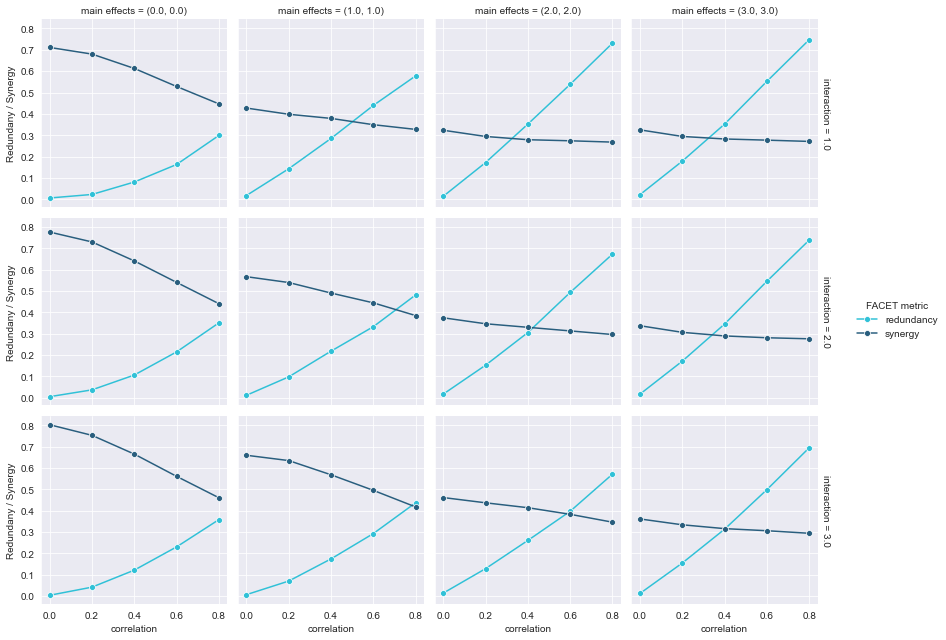

In [6]:
# load simulation study data
sns.set_style("darkgrid")

sim1_data = pd.read_csv("sphinx/source/tutorial/classification_sim1.csv").set_index(
    ["main effects", "interaction", "correlation"]
)

long_sim1_data = sim1_data[["redundancy", "synergy"]].stack().reset_index()
long_sim1_data.rename(
    columns={"level_3": "FACET metric", 0: "Redundany / Synergy"}, inplace=True
)

# create summary plot
sns.set_palette(["#30c1d7", "#295e7e"])
g = sns.FacetGrid(
    long_sim1_data,
    col="main effects",
    row="interaction",
    hue="FACET metric",
    margin_titles=True,
)
g.map(
    sns.lineplot,
    "correlation",
    "Redundany / Synergy",
    estimator="mean",
    marker="o",
    ci=None,
)
g.add_legend()

Key take-aways from the plot above:


1. In general, the larger the interaction the higher the synergy will be computed by the model.
2. The greater the individual contributions of the features the lower the synergy will be computed by the model.
3. As the correlation increases, redundancy increases and synergy reduces.
4. Redundancy increases with increasing individual contributions of the features


Additional learnings:
- Removing a redundant feature is unlikely to significantly reduce predictive performance, whereas removing a synergistic feature could significantly reduce predictive performance.
- The example here uses linear correlation and interactions for simplicity. However, if the correlation or interaction between two features is non-linear this may not be identified through a typical exploratory data analysis.
- For both correlation and interaction, the extent to which they are reflected in the redundancy or synergy for two features depends upon the fitted model. For example, if there is an interaction but the model does not learn this during training, then synergy will correspondingly be minimal.

# How overfitting affects the accuracy of redundancy and synergy estimates

In this second simulation study we are going to explore the values of synergy and redundancy as a function of regularization in a random forest. The main regularization parameter is the `max_depth`, which controls the tree depth. In general, the deeper the tree the more likely we are to overfit the data. Because we will apply cross-validation we can get a sense of how model performance improves and then degrades with `max_depth` using the cross-validation curve.

For this second simulation case study, we use the following parameters for data generation:

- intercept ($\beta_0$) = `[0]`
- main effects ($\beta_1, \beta_2$) = `[1]`
- interaction ($\beta_3$) = `[3]`
- correlation ($\rho$) = `[0.5]`

We simulate 20 datasets with 1000 observations. The classifier used is a Random Forest with default hyperparameters, except as follows:

- `max_depth = [2, 4, 8, 16, 32]`
- `n_estimators = [250]`

For each combination of parameters above we perform model fitting using 10 repeated 5-fold CV for each of the 20 simulated datasets.

The code used to generate the data presented is shown in the [Appendix](#Simulation-study-2-code). You can experiment with that code and perform your own simulation studies.

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


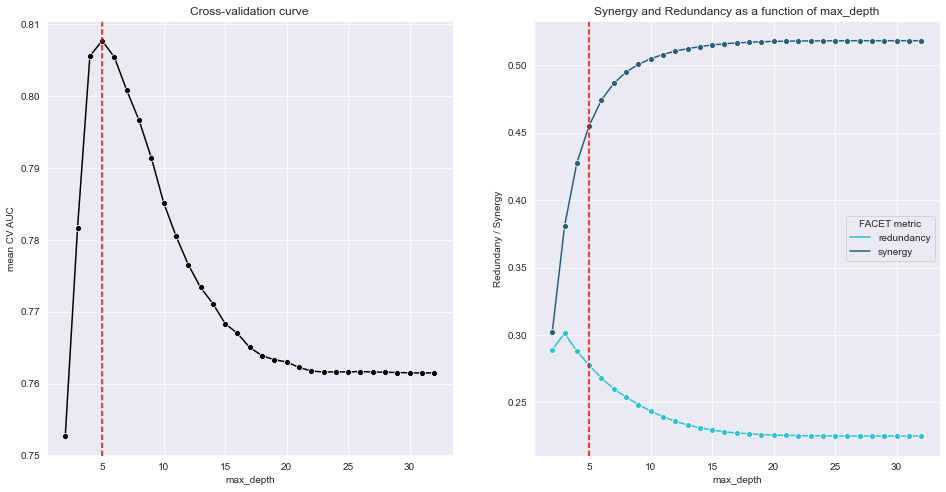

In [7]:
# load simulation study data
val_curve_df = pd.read_csv("sphinx/source/tutorial/classification_sim2_cvcurve.csv")
sim2_data = pd.read_csv("sphinx/source/tutorial/classification_sim2.csv").set_index(
    ["max_depth", "n_estimators"]
)
long_sim2_data = sim2_data[["redundancy", "synergy"]].stack().reset_index()
long_sim2_data.rename(
    columns={"level_2": "FACET metric", 0: "Redundany / Synergy"}, inplace=True
)
best_max_depth = val_curve_df.loc[val_curve_df["score"].idxmax(), "max_depth"]

# plot cross-validation curve from Learner Ranker
plt.subplots(figsize=(16, 8))
plt.subplot(1, 2, 1)
ax = sns.lineplot("max_depth", "score", data=val_curve_df, marker="o", color="black")
ax.set(xlabel="max_depth", ylabel="mean CV AUC", title="Cross-validation curve")
ax.axvline(best_max_depth, color="red", linestyle="--")

# create plot for redundancy and synergy as a function of max_depth
plt.subplot(1, 2, 2)
sns.set_palette(["#30c1d7", "#295e7e"])
ax = sns.lineplot(
    "max_depth",
    "Redundany / Synergy",
    data=long_sim2_data,
    hue="FACET metric",
    estimator="mean",
    marker="o",
    ci=None,
)
ax.set(title="Synergy and Redundancy as a function of max_depth")
ax.axvline(best_max_depth, color="red", linestyle="--")

We can observe the following from the figure above:

1. Based on the cross-validation curve, the best choice of `max_depth` is 5.
2. The value of synergy at the best `max_depth` of 5 is around 46% which is lower than the largest estimate of 53% when we overfit (right of `max_depth` = 5), and much greater than the smallest estimate of 30% when we underfit (left of `max_depth` = 5).
3. The value of redundancy at the best `max_depth` of 5 is around 27% which is higher than the smallest estimate of 23% when we overfit (right of `max_depth` = 5), and lower than the highest estimate of 30% when we underfit (left of `max_depth` = 5).

This suggests for a pair of moderately correlated features with a moderate interaction and limited individual contributions, overfitting might cause us to over-estimate synergy (i.e., the model interprets noise as an interaction) and under-estimate redundancy, while underfitting can cause the opposite. As with all machine learning, identifying a well-tuned model is critical to obtaining appropriate estimates of synergy and redundancy.

# Summary

We conducted two simulation studies using a simple controlled setting where we knew the amount of correlation, individual and combined contributions to a binary target.

- In the first simulation study we saw that the amount of correlation between two features as well as the strength of combined and independent contributions drive the balance between synergy and redundancy. 
- In the second simulation study we saw how both synergy and redundancy changed as a function of the `max_depth` parameter of our Random Forest classifier. For a pair of features with correlation and interaction, as `max_depth` increased synergy increased and redundancy decreased.

# What can you do next?

There are several next steps that could be taken to gain further intuition regarding the capabilities of FACET:
    
1. Explore further values of main-effects, interaction and correlation between the two features used in the simulation studies
2. Add further features to the simulation and explore what happens when you have features that are correlated but only one contributes to prediction (i.e., a purely redundant feature).
3. Try different learners and hyperparameters and see how the redundancy and synergy results change. **Remember, the contributions of features to individual predictions is through the "eyes" of the model.**

# Appendix

## Data simulation code

```python
def sim_interaction(
    n: int = 1000,
    intercept: float = None,
    coef_1: float = None,
    coef_2: float = None,
    coef_3: float = None,
    corr: float = 0
):

    # two standard normal features for the interaction term in the linear predictor
    # mean and standard deviation of each feature
    mu = [0, 0]
    sd_mat = [1, 1]
    
    # correlation matrix
    corr_mat = np.array([[1, corr], [corr, 1]])

    # mean and standard deviation of each feature
    mu = [0, 0]
    sd_mat = [1, 1]

    # calculate covariance
    cov_mat = sd_mat*corr_mat*sd_mat
    
    tmp_data = pd.DataFrame(
        np.random.multivariate_normal(mu, cov_mat, size=n),
        columns=["feature_1", "feature_2"],
    )

    # linear predictor
    lp = (
        intercept
        + coef_1 * tmp_data.feature_1
        + coef_2 * tmp_data.feature_2
        + coef_3 * tmp_data.feature_1 * tmp_data.feature_2
    )

    # convert to probability
    prob = 1 / (1 + np.exp(-lp))

    # create target
    tmp_data["target"] = np.where(prob <= np.random.uniform(size=n), 0, 1)

    return tmp_data
```

## Simulation study 1 code

```python
# conditions to iterate over
main_effects = [0, 1, 2, 3]
interaction = [1, 2, 3]
corr = [0, 0.2, 0.4, 0.6, 0.8]
conditions = list(itertools.product(*[main_effects, interaction, corr]))
n_sims = 20
n_conditions = len(conditions)
full_results = pd.DataFrame([])

# iterate over conditions
for i in range(n_conditions):
    
    print(i)
    
    print(i)
    
    # number of iterations for a set of conditions
    for j in range(n_sims):
        
        print(j)
        
        # simulate data
        sim_df = sim_interaction(intercept=0,
                                 n=2000,
                                 coef_1=conditions[i][0],
                                 coef_2=conditions[i][0],
                                 coef_3=conditions[i][1],
                                 corr=conditions[i][2])
        
        # run crossfit
        crossfit = LearnerCrossfit(
            pipeline=ClassifierPipelineDF(classifier=RandomForestClassifierDF(random_state=42)),
            cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
            n_jobs=-1,
        ).fit(sample = Sample(
            observations=sim_df,
            feature_names=['feature_1', 'feature_2'],
            target_name='target'
        ))

        # do a straight crossfit with fit inspector
        inspector = LearnerInspector(n_jobs=-1).fit(crossfit=crossfit)

        # obtain synergy and redundancy
        redundancy_matrix = inspector.feature_redundancy_matrix()
        synergy_matrix = inspector.feature_synergy_matrix()
        
        # assemble results
        tmp_results = pd.Series({'coef_1': conditions[i][0],
                   'coef_2': conditions[i][0],
                   'interaction': conditions[i][1],
                   'correlation': conditions[i][2],
                   'redundancy': redundancy_matrix.loc['feature_1', 'feature_2'],
                   'synergy': synergy_matrix.loc['feature_1', 'feature_2'],
                   'y_mean': sim_df.target.mean()})
        
        full_results = full_results.append(tmp_results, ignore_index=True)
        
full_results['main effects'] = "(" + full_results['coef_1'].astype(str) + ", " + full_results['coef_2'].astype(str) + ")"

# output to a csv file - and use in generating notebook
full_results.to_csv('sphinx/source/tutorial/classification_sim1.csv', index=False)
```

## Simulation study 2 code

First create a validation curve for `max_depth`.

```python
# hyperparameters to investigate
max_depth = list(np.arange(2,33))
n_estimators = [250]

# simulate train data
sim_df = sim_interaction(n=1000,
                         intercept=0,
                         coef_1=1,
                         coef_2=1,
                         coef_3=3,
                         corr=0.5)

# create classifier with required hyperparameters
rf_pipeline = ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(random_state=42)
)
rf_grid = LearnerGrid(
    pipeline=rf_pipeline,
    learner_parameters={'max_depth': max_depth,
                        'n_estimators': n_estimators}
)

# use learner ranker to assess hyperparameters to create a validation curve for max_depth
ranker = LearnerRanker(
    grids=[rf_grid],
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring='roc_auc'
).fit(sample = Sample(
    observations=sim_df,
    feature_names=['feature_1', 'feature_2'],
    target_name='target')
)

# grab data for the plot
result = ranker.summary_report()
result.columns = result.columns.map('_'.join)
result.rename(columns={'roc_auc_mean': 'score', 'classifier_max_depth':'max_depth'}, inplace=True)

# save dataset for plotting
result.to_csv('sphinx/source/tutorial/classification_sim2_cvcurve.csv', index=False)
```

Next, we run a simulation to assess the change in synergy and redundancy.

```python
# hyperparameters to investigate
max_depth = list(np.arange(2,33))
n_estimators = [250]

parm_grid = list(itertools.product(*[max_depth, n_estimators]))
n_sims = 20
n_parms = len(parm_grid)
full_results = pd.DataFrame([])

# number of iterations for a set of conditions
for j in range(n_sims):
    
    print(j)
        
    # simulate train data
    sim_df = sim_interaction(n=1000,
                             intercept=0,
                             coef_1=1,
                             coef_2=1,
                             coef_3=3,
                             corr=0.5)
    
    # iterate over hyperparameters
    for i in range(n_parms):
        
        print(i)
        
        # create classifier with required hyperparameters
        clf = ClassifierPipelineDF(
            classifier=RandomForestClassifierDF(
                random_state=42,
                max_depth=parm_grid[i][0],
                n_estimators=parm_grid[i][1]
            )
        )
        
        # run crossfit
        crossfit = LearnerCrossfit(
            pipeline=clf,
            cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
            n_jobs=-1,
        ).fit(sample = Sample(
            observations=sim_df,
            feature_names=['feature_1', 'feature_2'],
            target_name='target'
        ))

        # do a straight crossfit with fit inspector
        inspector = LearnerInspector(n_jobs=-1).fit(crossfit=crossfit)

        # obtain synergy and redundancy
        redundancy_matrix = inspector.feature_redundancy_matrix()
        synergy_matrix = inspector.feature_synergy_matrix()
        
        # assemble results
        tmp_results = pd.Series({'max_depth': parm_grid[i][0],
                   'n_estimators': parm_grid[i][1],
                   'redundancy': redundancy_matrix.loc['feature_1', 'feature_2'],
                   'synergy': synergy_matrix.loc['feature_1', 'feature_2'],
                   'y_mean': sim_df.target.mean()})
        
        full_results = full_results.append(tmp_results, ignore_index=True)
        
# output to a csv file - and use in generating notebook
full_results.to_csv('sphinx/source/tutorial/classification_sim2.csv', index=False)
```